In [0]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, multiply, BatchNormalization, Concatenate, Input
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers.advanced_activations import LeakyReLU


Using TensorFlow backend.


In [0]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-krkszm59
  Stored in directory: /tmp/pip-ephem-wheel-cache-pu9kcl8i/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from PIL import Image
import os 
import numpy as np
import random
from imageio import imread

In [0]:
a_train=[]
a_path='/content/gdrive/My Drive/data_science/dataset/V/trainA/'
for frame in os.listdir(a_path):
  i_path=a_path+frame
  if not frame.startswith('.'):
    a_train.append(i_path)
  

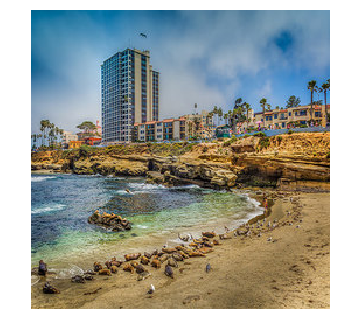

In [0]:
import matplotlib.pyplot as plt
a_img=imread(b_train[random.randint(0,100)])
plt.axis('off')
plt.imshow(a_img)

In [0]:
b_train=[]
b_path='/content/gdrive/My Drive/data_science/dataset/V/trainB/'
for frame in os.listdir(b_path):
  i_path=b_path+frame
  if not frame.startswith('.'):
    b_train.append(i_path)

In [0]:
def build_discriminator():
  def d_layer(layer_input ,filters,f_size=(4,4)):
    d=Conv2D(filters,kernel_size=f_size,strides=2,padding='same')(layer_input)
    d=LeakyReLU(alpha=0.2)(d)
    d=InstanceNormalization()(d)
    return d
  img=Input(shape=(256,256,3))
  d1=d_layer(img,64)
  d2=d_layer(d1,128)
  d3=d_layer(d2,256)
  d4=d_layer(d3,512)
  validity=Conv2D(1,kernel_size=4,strides=1,padding='same')(d4)
  return Model(img,validity)

In [0]:
def d_layer(layer_input ,filters,f_size=(4,4)):
    d=Conv2D(filters,kernel_size=f_size,strides=2,padding='same')(layer_input)
    d=LeakyReLU(alpha=0.2)(d)
    d=InstanceNormalization()(d)
    return d
def build_generator():
  def conv2d(layer_input ,filters,f_size=(4,4)):
    d=Conv2D(filters,kernel_size=f_size,strides=2,padding='same')(layer_input)
    d=LeakyReLU(alpha=0.2)(d)
    d=InstanceNormalization()(d)
    return d
  def deconv2d(layer_input, skip_input,filters,f_size=(4,4)):
    u=UpSampling2D(size=(2,2))(layer_input)
    u=Conv2D(filters,kernel_size=f_size,strides=1,padding='same')(u)
    u=LeakyReLU(alpha=0.2)(u)
    u=InstanceNormalization()(u)
    u=Concatenate()([u,skip_input])
    return u
  
  d0=Input(shape=(256,256,3))
  d1=conv2d(d0,32)
  d2=d_layer(d1,64)
  d3=d_layer(d2,128)
  d4=d_layer(d3,256)
  u1=deconv2d(d4,d3,128)
  u2=deconv2d(u1,d2,64)
  u3=deconv2d(u2,d1,32)
  #u4=deconv2d(u2,d1,32)
  
  u4=UpSampling2D(size=(2,2))(u3)
  output_img=Conv2D(3,kernel_size=(4,4),strides=1,padding='same',activation='tanh')(u4)
  
  
  return Model(d0,output_img)
  

In [0]:
from keras.optimizers import Adam
op=Adam(0.0002,0.5)
d_A=build_discriminator()
d_A.compile(loss='mse',optimizer=op,metrics=['accuracy'])
d_B=build_discriminator()
d_B.compile(loss='mse',optimizer=op,metrics=['accuracy'])
#d_A.summary()

In [0]:
g_AB=build_generator()
g_BA=build_generator()
img_A=Input(shape=(256,256,3))
img_B=Input(shape=(256,256,3))
fake_B=g_AB(img_A)
fake_A=g_BA(img_B)
reconstr_A=g_BA(fake_B)
reconstr_B=g_AB(fake_A)
img_A_id=g_BA(img_A)
img_B_id=g_AB(img_B)
d_A.trainable=False
d_B.trainable=False
valid_A=d_A(fake_A)
valid_B=d_B(fake_B)
combined=Model(inputs=[img_A,img_B],outputs=[valid_A,valid_B,reconstr_A,reconstr_B,img_A_id,img_B_id])
combined.compile(loss=['mse','mse','mae','mae','mae','mae'],loss_weights=[1,1,10,10,1,1],optimizer=op)

In [0]:
patch=int(256/16)
disc_patch=(patch,patch,1)
valid=np.ones((1,)+disc_patch)
fake=np.zeros((1,)+disc_patch)
batch_size=1
train_count=10
d_loss_list=[]
g_loss_list=[]



In [0]:
from tqdm import tqdm
for train in tqdm(range(0,train_count)):
  dash='-'*15
  print(dash,'train',train,dash)
  ida=np.random.randint(0,len(a_train),batch_size)
  idb=np.random.randint(0,len(b_train),batch_size)
  imgs_A=[]
  imgs_B=[]
  for i in ida:
    imgs_A.append((imread(a_train[i])-150)/150)#imgs_A.append((imread(a_train[i])-127.5)/127.5)
  for i in idb:
    imgs_B.append((imread(b_train[i])-150)/150)
  imgs_A=np.array(imgs_A)  
  imgs_B=np.array(imgs_B)  
  fake_B=g_AB.predict(imgs_A)
  fake_A=g_BA.predict(imgs_B)
  d_A.trainable=True
  d_B.trainable=True
  dA_loss_real=d_A.train_on_batch(imgs_A,valid)
  dA_loss_fake=d_A.train_on_batch(fake_A,fake)
  dA_loss=0.5*np.add(dA_loss_real,dA_loss_fake)
  dB_loss_real=d_B.train_on_batch(imgs_B,valid)
  dB_loss_fake=d_B.train_on_batch(fake_B,fake)
  dB_loss=0.5*np.add(dB_loss_real,dB_loss_fake)
  d_loss=0.5*np.add(dB_loss_real,dB_loss_fake)
  
  d_loss=0.5*np.add(dA_loss,dB_loss)
  d_A.trainable=False
  d_B.trainable=False
  g_loss=combined.train_on_batch([imgs_A,imgs_B],[valid,valid,imgs_A,imgs_B,imgs_A,imgs_B])
  
  dash='-'*15
  print('discriminator loss',d_loss)
  print('genarator loss',g_loss)
  d_loss_list.append(d_loss)
  g_loss_list.append(g_loss)
  

  0%|          | 0/5 [00:00<?, ?it/s]

--------------- train 0 ---------------


 20%|██        | 1/5 [00:13<00:52, 13.19s/it]

discriminator loss [0.68331915 0.5654297 ]
genarator loss [10.632556, 0.7015813, 0.41952062, 0.38193482, 0.31492814, 0.905096, 1.6377287]
--------------- train 1 ---------------


 40%|████      | 2/5 [00:26<00:40, 13.34s/it]

discriminator loss [1.0260769 0.5263672]
genarator loss [14.223824, 1.0663216, 2.0852613, 0.38865477, 0.48161244, 0.9752806, 1.3942866]
--------------- train 2 ---------------


 60%|██████    | 3/5 [00:39<00:26, 13.17s/it]

discriminator loss [0.692158  0.6171875]
genarator loss [11.819132, 1.0059385, 0.37234822, 0.46643496, 0.3301383, 0.9539642, 1.5211483]
--------------- train 3 ---------------


 80%|████████  | 4/5 [00:52<00:13, 13.22s/it]

discriminator loss [0.2701993  0.75097656]
genarator loss [13.710701, 0.93940187, 1.536981, 0.3421752, 0.53986347, 0.98541474, 1.4285161]
--------------- train 4 ---------------


100%|██████████| 5/5 [01:06<00:00, 13.19s/it]

discriminator loss [0.06871166 0.91503906]
genarator loss [12.0008545, 1.0036008, 0.84373385, 0.29102314, 0.46603167, 0.90678835, 1.6761835]


(-0.5, 255.5, 255.5, -0.5)

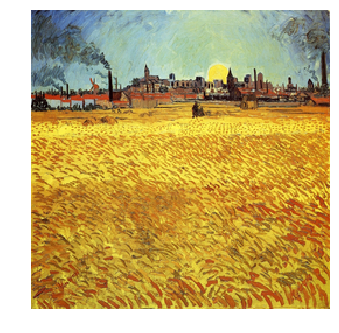

In [0]:
idx=random.randint(0,len(a_train)-1)
drawing=imread(a_train[idx])
plt.imshow(drawing)
plt.axis('off')

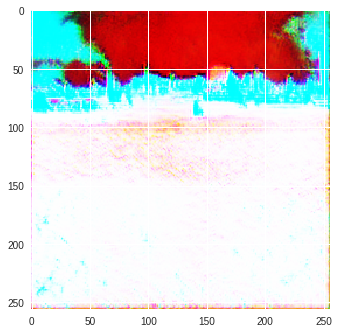

In [0]:
drawing_shaped=(drawing-125.5)/125.5
fake_scenery=g_AB.predict(np.array([drawing_shaped]))
fake_scenery=0.5*fake_scenery+0.5
plt.imshow(fake_scenery[0])

In [0]:
drawb=5
idx=np.random.randint(0,len(b_train),drawb)
scenery_batch=[]
drawing_batch=[]
reconstruct_batch=[]
for i in idx:
  scenery_i=imread(b_train[i])
  scenery_i_shaped=(scenery_i-127.5)/127.5
  scenery_batch.append(scenery_i)
  fake_drawing_i=g_BA.predict(np.array([scenery_i_shaped]))
  reconstruct_i=g_AB.predict(fake_drawing_i)
  fake_drawing_i=0.5*fake_drawing_i+0.5
  drawing_batch.append(fake_drawing_i[0])
  reconstruct_i=0.5*reconstruct_i+0.5
  reconstruct_batch.append(reconstruct_i[0])  

In [0]:
idx

array([ 444, 3851, 3969, 2627, 1946])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


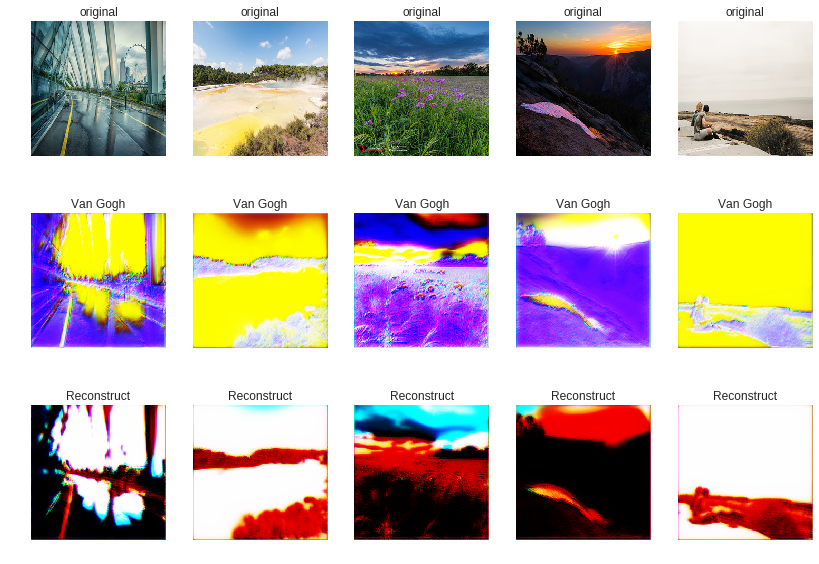

In [178]:
plt.figure(figsize=(14,10))
for (i, draw) in enumerate(scenery_batch):
  plt.subplot(3,drawb,i+1)
  plt.title('original')
  plt.axis('off')
  plt.imshow(draw)
for (i, draw) in enumerate(drawing_batch):
  plt.subplot(3,drawb,drawb+i+1)
  plt.title('Van Gogh')
  plt.axis('off')
  plt.imshow(draw)
for (i, draw) in enumerate(reconstruct_batch):
  plt.subplot(3,drawb,2*drawb+i+1)
  plt.title('Reconstruct')
  plt.axis('off')
  plt.imshow(draw)